<h1 align="center"> XGBoost Vs LightGBM - A Tutorial</h1> 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample


# matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# enable static images of your plot embedded in the notebook
%matplotlib inline 

# seaborn
import seaborn as sns
sns.set() #apply the default default seaborn theme, scaling, and color palette

import lightgbm as lgb
import xgboost as xgb


import catboost
from catboost import *
from catboost import datasets
from catboost import Pool

**Data Preparation**

In [2]:
(df_train, df_test) = catboost.datasets.amazon()

In [3]:
df_train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
df_train.rename(columns={"ACTION": "TARGET"}, inplace= True)
df_test.rename(columns={"ACTION": "TARGET"},  inplace= True)

In [5]:
df_train['TARGET'].value_counts()

1    30872
0     1897
Name: TARGET, dtype: int64

In [6]:
numerical_features = list(df_train.select_dtypes([np.number]).columns)
categorical_features = list(set(df_train.columns).difference(set(numerical_features)))

In [7]:
categorical_features


[]

In [8]:
df_train.shape

(32769, 10)

In [9]:
df_train.describe()

,TARGET,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
TARGET              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB


In [11]:
df_test.shape

(58921, 10)

In [12]:
df_test.describe()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,58921.000000,58921.000000,58921.000000,58921.000000,58921.000000,58921.000000,58921.000000,58921.000000,58921.00000,58921.000000
mean,29461.000000,39383.739482,26691.645050,117028.638041,118316.334091,118858.006721,126358.019993,170455.861425,179278.05896,119707.754264
std,17009.171942,33717.397122,35110.244281,10805.446548,4284.678750,17916.179109,32068.294507,69684.692799,99639.96530,5326.979178
min,1.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.00000,117880.000000
25%,14731.000000,18418.000000,4663.000000,117961.000000,118096.000000,118378.000000,118259.000000,117913.000000,118331.00000,118055.000000
50%,29461.000000,33248.000000,14789.000000,117961.000000,118300.000000,118910.000000,118636.000000,129282.000000,118704.00000,118570.000000
75%,44191.000000,45481.000000,46512.000000,117961.000000,118386.000000,120410.000000,120006.000000,234813.000000,290919.00000,119353.000000
max,58921.000000,312136.000000,311779.000000,311178.000000,194897.000000,277693.000000,311867.000000,311867.000000,308574.00000,270691.000000


In [13]:
df_train['TARGET'].value_counts()

1    30872
0     1897
Name: TARGET, dtype: int64

In [14]:
df_train.isna().sum()

TARGET              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [15]:
df_test.isna().sum()

id                  0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [16]:
Features = list(df_train.columns)
Features.remove('TARGET')
cat_features = list(range(df_train.drop("TARGET",1).shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [17]:
our_x_train = df_train[Features]
our_y_train = df_train['TARGET']
our_x_test = df_test[Features]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(our_x_train,
                                                    our_y_train,
                                                    test_size=0.33,
                                                    random_state=17)

In [19]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21955, 9) (10814, 9) (21955,) (10814,)


In [20]:
# checking the label balance in dataset
im_check = df_train.TARGET.value_counts()

print("class 1:", im_check[1]/sum(im_check))
print("class 0:", im_check[0]/sum(im_check))

display(im_check)

class 1: 0.9421099209618847
class 0: 0.05789007903811529


1    30872
0     1897
Name: TARGET, dtype: int64

In [21]:
# Separate classes
class_0 = df_train[df_train.TARGET == 0]
class_1 = df_train[df_train.TARGET == 1]

# Downsample majority class
down_1_class = resample(class_1,
                        n_samples=1897,    # to match minority class
                        random_state=10)  # reproducible results


# Combine minority class with downsampled majority class
down_df = pd.concat([down_1_class, class_0])

# Join together class 0's target vector with the downsampled class 1's target vector
down_df.TARGET.value_counts()


# downsampled_df
X_dtrain, X_dvalid, y_dtrain, y_dvalid = train_test_split(
    down_df.drop('TARGET', axis=1), down_df.TARGET, train_size=0.8, random_state=950)



In [22]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    """
    pd.crosstab() - crosstab function builds a cross-tabulation table that can show the 
                    requency with which certain groups of data appear.
    
    """
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                                   rownames=['Actual'],
                                   colnames=['Predicted'])
    
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    
    if title is None:
        pass
    else:
        plot.set_title(title)
        
    plt.show()

**Introduction and Overview.**

The popular algorithms XGBoost and LightGBM are both variants of Gradient Boosting Decision Trees. 

Both algorithms use a greedy approach to minimising the gradient of loss function to build an ensemble of weak learners. Both algorithms use a leaf wise strategy rather than a level wise strategy to build the trees

As the algorithms are very frequently updated, the features are pretty much common between the algorithms. It can be difficult to compare the two in terms of which performance. The choice would depend on the data and the problem at hand. 

The main challenge of these methods is that finding the best split points of the trees in time consuming and memory consuming operations.Both LightGBM and XGBoost can use different optimisation techniques or methods to identify the best split point

**Light GBM**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.
**

Let us see what version of LightGBM we have got!!

In [23]:
print("LightGBM version:", lgb.__version__)

LightGBM version: 2.3.0


**LightGBM Parameters**

LightGBM supports a huge list of parameters that can be finetuned according to the problem we have at hand. 

**Data Handling Features of LightGBM**

In this specific example, we can see two problems from a data preprocessing perspective:
1. Class Imbalance
2. Categorical Features Handling
3. Handling of missing values


**Class Imbalance**

LightGBM has inbuilt features for handling Class Imbalance and provides two paramters to handle Class Imbalance:  'is_unbalance' and 'scale_pos_weight'. Let us compare using these parameters against manual downsampling. We will also plot and compare how the *Feature Importance* **changes in the three cases

In [24]:
def run_lgb(X_train, X_test, y_train, y_test, finetuned_params, title):
    FIXED_PARAMS={'objective': 'binary',
              'metric': 'auc',
              'boosting':'gbdt',
              'num_boost_round':300,
              'verbosity' : -1}
    
    params={**FIXED_PARAMS, **finetuned_params}
    lgtrain = lgb.Dataset(X_train, label= y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    
    print("Accuracy", accuracy_score(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred,title)
   
    lgb.plot_importance(booster = model, title =title)
    

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Accuracy 0.7470355731225297


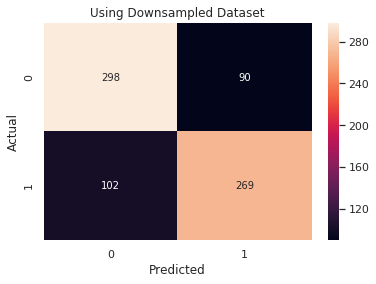

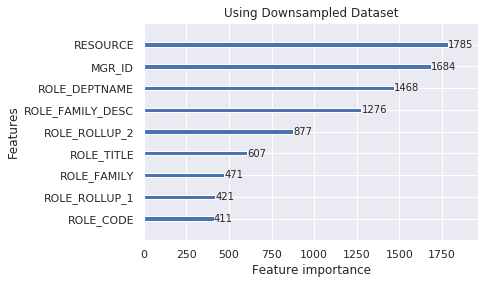

In [25]:
params_downsampling = {}
run_lgb(X_dtrain, X_dvalid, y_dtrain, y_dvalid,params_downsampling,"Using Downsampled Dataset" )


Accuracy 0.9066950249676345


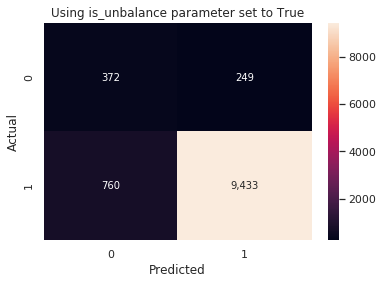

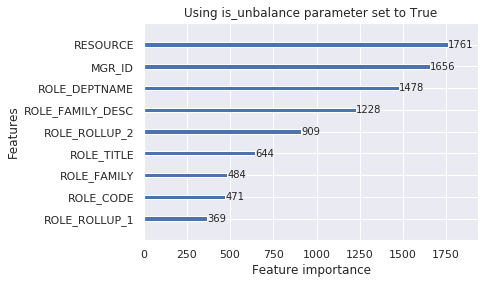

In [26]:
params_class_imbalance = {'is_unbalance':True}
run_lgb(X_train, X_test, y_train, y_test,params_class_imbalance,"Using is_unbalance parameter set to True" )


Accuracy 0.9050305159977806


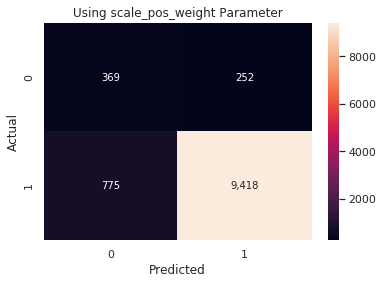

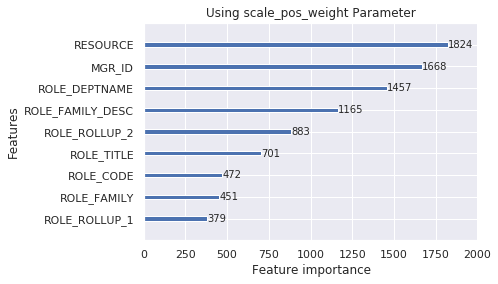

In [27]:

params_scale_pos_weight = {'scale_pos_weight':im_check[0]/im_check[1]}
run_lgb(X_train, X_test, y_train, y_test,params_scale_pos_weight,"Using scale_pos_weight Parameter" )

We can conclude that the lightGBM parameters 'is_unbalance' and 'scale_pos_weight' provides significant improvement in accuracy and is definitely better than using manual downsampling.

Among the two parameters, using the 'is_unbalance' feature performs slightly better than 'scale_pos_weight' in this dataset.

**Handling of Categorical Features.**

LightGBM provides support for handling categorical features. It is possible to provide the list of categorical features in a dataset using the *'cat_features'* parameter.


Let us compare performance after using this feature

Accuracy 0.9050305159977806


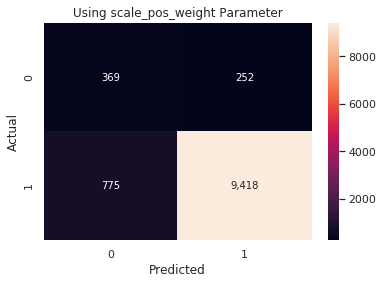

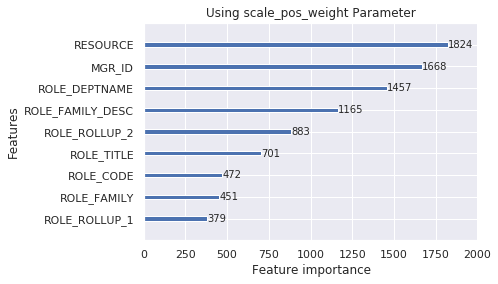

In [28]:
params_scale_pos_weight = {'scale_pos_weight':im_check[0]/im_check[1]}
run_lgb(X_train, X_test, y_train, y_test,params_scale_pos_weight,"Using scale_pos_weight Parameter" )

Accuracy 0.9066950249676345


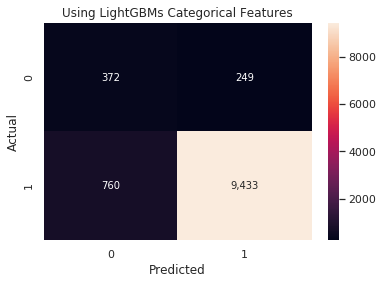

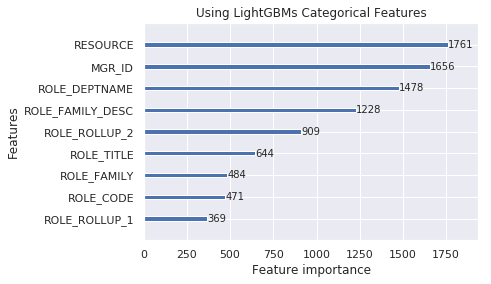

In [29]:
params_cat_features = {'cat_feature' : cat_features,
                      'scale_pos_weight':im_check[0]/im_check[1]}
run_lgb(X_train, X_test, y_train, y_test,params_class_imbalance,"Using LightGBMs Categorical Features" )


There is a noticeable improvement in accuracy when the cat_features parameter is used.

**Handling of NA and missing values.**

Missing values can be handled using below LightGBM parameters
* use_missing 🔗︎, default = true, type = bool

    set this to false to disable the special handle of missing value

* zero_as_missing 🔗︎, default = false, type = bool

    set this to true to treat all zero as missing values (including the unshown values in LibSVM / sparse matrices)

    set this to false to use na for representing missing values
    
When categorical features are specified, all negative values will be treated as missing values

PS: We do not have any missing values in this Dataset


**Important Hyperparameters and Tuning:**

LightGBM supports a large assortment of parameters that can be used to control the performance of the model. Some of the most importance parameters are listed below.

*Core parameters*

* objective 🔗︎ To specify the model objective

    Can take values like 'regression'. 'binary', 'multiclass'

* boosting 🔗︎ To specify the boosting type

    Can take values like 'gbdt', 'rf' , 'dart' , 'goss'
    
* num_iterations 🔗︎, default = 100

    Number of boosting iterations

* learning_rate 🔗︎ Learning rate for the algorithm

  

*Learning Control Parameters*
* max_depth 🔗︎, Used to deal with over-fitting when #data is small. Tree still grows leaf-wise

* min_data_in_leaf 🔗︎,minimal number of data in one leaf. Can be used to deal with over-fitting
    
* pos_bagging_fraction, neg_bagging_fraction 🔗︎,  used only in binary application, used for imbalanced binary classification problem


* feature_fraction 🔗︎ LightGBM will randomly select part of features on each iteration (tree) if feature_fraction smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree. Can be used to speed up training and to deal with over-fitting

*IO Parameters*
    
* max_bin 🔗︎, max number of bins that feature values will be bucketed in, small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)

*Metric Parameters*
* metric 🔗︎, Can take values 'mse','rmse','mae','auc' etc

    metric(s) to be evaluated on the evaluation set(s)
 

**Grid Search for LightGBM Hyperparameter Tuning**

In [30]:
def run_lgb_gridsearch(X_train, X_test, y_train, y_test,  our_x_test):
    SEARCH_PARAMS = {'learning_rate': 0.4,
                 'max_depth': 15,
                 'num_leaves': 20,
                 'feature_fraction': 0.8,
                 "bagging_fraction" : 0.6,
                 "bagging_frequency" : 6,
                 "bagging_seed" : 42,
                 'subsample': 0.2}

    FIXED_PARAMS={'objective': 'binary',
              'metric': 'auc',
              'is_unbalance':True,
              'early_stopping_rounds':30,
              'verbosity' : -1}
    
    params = {'metric':FIXED_PARAMS['metric'],
             'objective':FIXED_PARAMS['objective'],
             'verbosity' :FIXED_PARAMS['verbosity'],
             'is_unbalance':FIXED_PARAMS['is_unbalance'],
             **SEARCH_PARAMS}
    
    grid = {'learning_rate': [0.03, 0.1],
        "num_leaves" : [20,30,40],
        'max_depth':  [4, 6, 10],
        'boosting':['gbdt', 'dart','goss'],
        'num_boost_round':[100,200,300],
        }
    

    model = lgb.LGBMClassifier(**params)
    
    grid = GridSearchCV(model, grid,
                    verbose=0,
                    cv=3,
                    n_jobs=2)
    # Run the grid
    grid.fit(X_train,y_train)
    print(grid)
    # Print the best parameters found
    print(grid.best_params_)
    print(grid.best_score_)

    # Using parameters already set above, replace in the best from the grid search
    params['learning_rate'] = grid.best_params_['learning_rate']
    params['num_leaves'] = grid.best_params_['num_leaves']
    params['max_depth'] = grid.best_params_['max_depth']
    params['boosting'] = grid.best_params_['boosting']
    params['num_boost_round'] = grid.best_params_['num_boost_round']

    model.fit(X_train,y_train)
    pred_test_y = model.predict(our_x_test)
    
    
    #pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model

In [31]:
pred_test, model = run_lgb_gridsearch(X_train, X_test, y_train, y_test, our_x_test)
print("LightGBM Training Completed...")
model

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_fraction=0.6, bagging_frequency=6,
                                      bagging_seed=42, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      is_unbalance=True, learning_rate=0.4,
                                      max_depth=15, metric='auc',
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_spl...
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=0.2,
                                      subsample_for_bin=200000,
                                      subsample_freq=0, verbosity=-1),
     

LGBMClassifier(bagging_fraction=0.6, bagging_frequency=6, bagging_seed=42,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.8, importance_type='split', is_unbalance=True,
               learning_rate=0.4, max_depth=15, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=20, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.2, subsample_for_bin=200000, subsample_freq=0,
               verbosity=-1)

**LightGBM Cross Validation**

LightGBM supports for in- built crossvalidation using LightGBM.cv

In [32]:
dftrainLGB = lgb.Dataset(data = X_train, label = y_train)

params = {'objective': 'binary'}


lgb_cv_results = lgb.cv(
        params,
        dftrainLGB,
        num_boost_round=100,
        nfold=3,
        metrics='mae',
        early_stopping_rounds=10,
        stratified=False
        )

lgb_cv_results

{'l1-mean': [0.10915226655186834,
  0.10873496529335532,
  0.10833276444459546,
  0.10786969327223676,
  0.10736332019243179,
  0.10691638924086518,
  0.10649017746114191,
  0.10604609311997604,
  0.10558001301583914,
  0.10526797543083483,
  0.10490382996725744,
  0.10448982810759473,
  0.10416049597803241,
  0.10379010085559849,
  0.10339569790168934,
  0.10306896874854925,
  0.10276835268589991,
  0.10245465390185678,
  0.10208758767777404,
  0.10182945256259764,
  0.10152244192371139,
  0.10124268355288518,
  0.10094934639041138,
  0.10066641621648925,
  0.10037652725822573,
  0.1000272505027902,
  0.09977089041943694,
  0.09961002740456106,
  0.09934004439316002,
  0.09909561231225035,
  0.09889460905589349,
  0.09870644427120107,
  0.098523805452415,
  0.09830789707773997,
  0.09806969200608551,
  0.0979640553291955,
  0.0978831645395521,
  0.09771822353932529,
  0.09749755699808212,
  0.09732537522829225,
  0.09713965124849133,
  0.09695653264752092,
  0.0967715762294518,
  0.09

**XGBoost**

XGBoost stands for eXtreme Gradient Boosting.The implementation of the model supports the features of the scikit-learn and R implementations, with new additions like regularization. Three main forms of gradient boosting are supported:

*     Gradient Boosting algorithm also called gradient boosting machine including the learning rate.
*     Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels.
*     Regularized Gradient Boosting with both L1 and L2 regularization.


Checking the version of XGBoost..

In [33]:
print("XGBoost version:", xgb.__version__)

XGBoost version: 0.90


**Data Handling Features of XGBoost**


**Class Imbalance**
The implementation provides a hyperparameter designed to tune the behavior of the algorithm for imbalanced classification problems; this is the scale_pos_weight hyperparameter.

By default, the scale_pos_weight hyperparameter is set to the value of 1.0 and has the effect of weighing the balance of positive examples, relative to negative examples when boosting decision trees. For an imbalanced binary classification dataset, the negative class refers to the majority class (class 0) and the positive class refers to the minority class (class 1).

Gradients are used as the basis for fitting subsequent trees added to boost or correct errors made by the existing state of the ensemble of decision trees.

The scale_pos_weight value is used to scale the gradient for the positive class.

This has the effect of scaling errors made by the model during training on the positive class and encourages the model to over-correct them. In turn, this can help the model achieve better performance when making predictions on the positive class. Pushed too far, it may result in the model overfitting the positive class at the cost of worse performance on the negative class or both classes.

As such, the scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the scale_pos_weight can be set to 100. This will give classification errors made by the model on the minority class (positive class) 100 times more impact, and in turn, 100 times more correction than errors made on the majority class.

Let us run XGBoost on  a manually downsampled dataset and then compare the XGBoost performance when using the scale_pos_weight parameter.

In [34]:
def run_xgb(X_train, X_test, y_train, y_test, finetuned_params, title):
    
    FIXED_PARAMS={'objective':'binary:logistic',
              'eval_metric': 'auc',
              'num_boost_round':300,
              'eta': 0.001,
              'max_depth': 10, 
              'subsample': 0.6, 
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42, 
              'silent':True}

    params={**FIXED_PARAMS, **finetuned_params}
    model_xgb = xgb.XGBClassifier(**params)
    #model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    print("Accuracy", accuracy_score(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred,title)
    xgb.plot_importance(model_xgb)
    plt.show()
    
    
    

Accuracy 0.7483530961791831


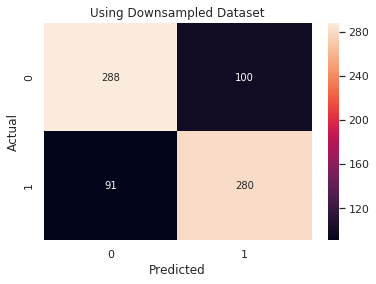

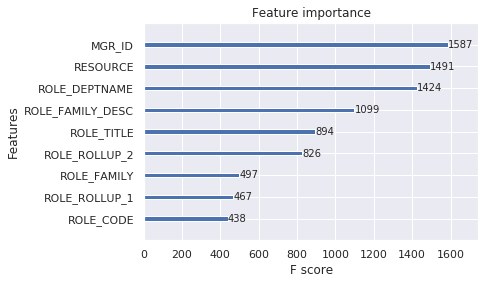

In [35]:
params_downsampling = {}
run_xgb(X_dtrain, X_dvalid, y_dtrain, y_dvalid,params_downsampling,"Using Downsampled Dataset" )


Accuracy 0.8845940447567967


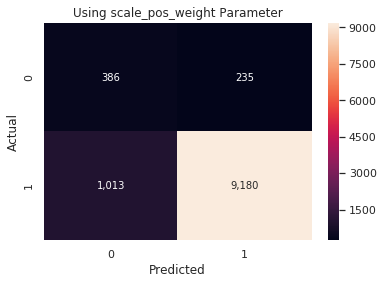

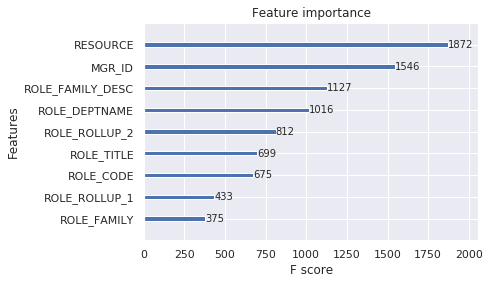

In [36]:
params_scale_pos_weight = {'scale_pos_weight':im_check[0]/im_check[1]}
run_xgb(X_train, X_test, y_train, y_test,params_scale_pos_weight,"Using scale_pos_weight Parameter" )

**Categorical Features Handling**

XGBoost works only on numerical data. Hence categorical data needs to be encoded to numeric before it can be modelled.

One Hot encoding or Label encoding maybe used to this regard. 




**Handling Missing Values and NA**

xgboost decides at training time whether missing values go into the right or left node. It chooses which to minimise loss. If there are no missing values at training time, it defaults to sending any new missings to the right node.

If Data has NaNs encoded as -1 or 0 or any other value, we can tell XGBOOST this to the algorithm using the parameter 'missing_value'. Eg:  missing_value=-65336:

**Important Hyperparameters and Tunning:**

XGBoost parameters are grouped to below four categories. A few important ones are mentioned below


*General Parameters*

* booster  🔗︎  Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions

* verbosity. 🔗︎ Verbosity of printing messages. Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). Sometimes XGBoost tries to change configurations based on heuristics, which is displayed as warning message. If there’s unexpected behaviour, please try to increase value of verbosity

*Booster parameters*

* eta  🔗︎  Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

* max_depth 🔗︎ Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit

* subsample 🔗︎ Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.


* lambda 🔗︎ L2 regularization term on weights. Increasing this value will make model more conservative

* alpha 🔗︎ L1 regularization term on weights. Increasing this value will make model more conservative.


*Learning task parameters*

* objective 🔗︎ Specify the learning task and the corresponding learning objective. Can take values like    reg:squarederror: regression with squared loss.
   reg:logistic: logistic regression
   binary:logistic: logistic regression for binary classification, output probability
   multi:softmax: set XGBoost to do multiclass classification using the softmax objective

* eval_metric 🔗︎ Evaluation metrics for validation data Can take values like rmse, mae, logloss, error etc


*Command line parameters*

Relate to behavior of CLI version of XGBoost.


**Grid Search and Hyperparameter Tuning**

In [37]:
def run_xgb_gridsearch(X_train, X_test, y_train, y_test,  our_x_test):
    params={'objective':'binary:logistic',
              'eval_metric': 'auc',
              'num_boost_round':300,
              'eta': 0.001,
              'max_depth': 10, 
              'alpha':0.001,
              'random_state': 42, 
              'silent':True}
    
    grid = {'learning_rate': [0.03, 0.1],
        "num_leaves" : [20,30,40],
        'max_depth':  [4, 6, 10],
        'num_boost_round':[100,200,300],
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)]
        }
    

    
    model_xgb = xgb.XGBClassifier(**params)
    
    grid = GridSearchCV(model_xgb, grid,
                    verbose=0,
                    cv=3,
                    n_jobs=2)
    # Run the grid
    grid.fit(X_train,y_train)
    print(grid)
    # Print the best parameters found
    print(grid.best_params_)
    print(grid.best_score_)

    # Using parameters already set above, replace in the best from the grid search
    params['learning_rate'] = grid.best_params_['learning_rate']
    params['num_leaves'] = grid.best_params_['num_leaves']
    params['max_depth'] = grid.best_params_['max_depth']
    params['num_boost_round'] = grid.best_params_['num_boost_round']
 

    model_xgb.fit(X_train,y_train)
    pred_test_y = model_xgb.predict(our_x_test)
    
    return   pred_test_y ,model_xgb

In [38]:
pred_test_y ,model= run_xgb_gridsearch(X_train, X_test, y_train, y_test, our_x_test)
print("XGBoost Training Completed...")
model

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(alpha=0.001, base_score=0.5,
                                     booster='gbtree', colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     eta=0.001, eval_metric='auc', gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, num_boost_round=300...
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=2,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'learning_rate': [0.03, 0.1], 'max_depth': [4, 6, 10],
                         'nu

XGBClassifier(alpha=0.001, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.001, eval_metric='auc', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None, num_boost_round=300,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1, verbosity=1)

**XGBoost In built - Cross Validation**


XGBoost supports for in- built crossvalidation using XGBoost.cv

In [39]:

data_dmatrix = xgb.DMatrix(X_train, y_train)
params = {'objective':'binary:logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="auc", as_pandas=True, seed=123)

cv_results


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.500000,0.000000,0.500000,0.000000
1,0.501282,0.001143,0.500713,0.000510
2,0.503085,0.000977,0.502464,0.002231
3,0.503085,0.000977,0.502464,0.002231
4,0.503084,0.000977,0.502464,0.002230
5,0.503084,0.000977,0.502464,0.002230
6,0.503084,0.000977,0.502464,0.002230
7,0.503084,0.000977,0.502464,0.002230
8,0.524352,0.031021,0.516467,0.018636
9,0.524784,0.030725,0.516982,0.018221


**Conclusion**

Both algorithms have similarities and dissimilarities and offer powerful features. The right choice of algorithm would depend on the data and the problem that we intend to solve.

**References**
* https://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/
* Kaggle Kernels - https://www.kaggle.com/samratp/lightgbm-xgboost-catboostKaggle Kernel - https://www.kaggle.com/prashant111/tutorial-lightgbm-classifier-in-python
* Kaggle Kernel - https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823
* https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
* https://xgboost.readthedocs.io
* https://lightgbm.readthedocs.io
* https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
* https://neptune.ai/blog/lightgbm-parameters-guide
* https://pyligent.github.io/2019-08-20-lightGBM_XGBoost/
* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
* https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/